## Antigenic Fitness  
### Can we quantify the extent to which antigenic novelty contributes to viral fitness?  

#### We make some simplifying assumptions. Specifically:  
* Antigenic fitness is primarily determined by the population of people that have had exactly 1 infection. Otherwise, we assume they are either entirely naive (unexposed) or entirely immune (post-secondary infection), and so their contributions to antigenic fitness are uniform for all genotypes and thus negligible for our purposes. On average, there is a 4-6 year gap between primary and secondary infections in endemic regions.  
* We assume incidence is approximately constant between seasons.  
* We assume unbiased sampling of genotypes.  
* We assume even mixing of genotypes within a region/country of analysis.

#### Antigenic fitness of genotype _i_ essentially depends on:  
* What genotypes, j1 -> jn have people most likely been exposed to in the last 5-6 years?  
* How long ago where they exposed to genotype j? Cross-protective immunity wanes over a period of 1-3 years.
* How antigenically similar are genotypes _i_ and _j_? 

#### Thus, we parameterize _Ti_ as a simple function of genotype frequencies and titer measurements.  

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from pprint import pprint
from itertools import permutations
from math import exp, ceil
from numpy import linspace, nanmax, nanmin
from matplotlib import cm
from itertools import combinations
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
# Pull pre-computed genotype frequencies
dataset_name = 'SEAsia_stiffness2'
out_path = '../../data/frequencies/regions'
frequency_path = '../../data/frequencies/regions/seAsia_stiffness2_pivots4.csv'
genotype_titer_path = '../../data/katzelnick2015/processed/genotypes_dTiters.csv'
serotype_titer_path = '../../data/katzelnick2015/processed/serotypes_dTiter.csv'

In [32]:
genotype_frequencies = pd.read_csv(frequency_path, index_col=0)

# Bin seasons by year
seasons = range(1980, 2017)

# Bin each pivot from augur (row in frequencies data) by which season it falls into. Average frequencies by season.
def bin_seasons(df, seasons=seasons):
    def find_season(date, seasons=seasons):
        if int(date) in seasons:
            return int(date)
        else:
            return np.nan
        
    df['season'] = [find_season(date, seasons) for date in df.index.values]
    df.dropna(how='any', inplace=True)
    df['season'] = df['season'].map(lambda x: int(x))
    df = df.groupby('season').agg('mean')
    return df

# serotype_frequencies = bin_seasons(serotype_frequencies, seasons)
genotype_frequencies = bin_seasons(genotype_frequencies, seasons)
genotype_frequencies.drop([g for g in genotype_frequencies if 'SYLVATIC' in g],axis=1, inplace=True)

def get_delta_frequencies(all_Y, years_forward, frequencies):
    valid_start = all_Y[:-1*years_forward]
    valid_end = all_Y[years_forward:]
    delta_Y = zip(valid_start, valid_end)
    delta_f = { i: [frequencies[i][end] - frequencies[i][start] for (start, end) in delta_Y] for i in frequencies.columns.values}
    return pd.DataFrame(delta_f, index=valid_start)

delta_genotype_frequencies = get_delta_frequencies(seasons, 5, genotype_frequencies)
print genotype_frequencies.head()
print delta_genotype_frequencies.head()

         DENV1_I  DENV1_II  DENV1_IV   DENV1_V  DENV2_AMERICAN  \
season                                                           
1980    0.328900  0.001375  0.054150  0.242000             0.0   
1981    0.502475  0.000600  0.082750  0.041775             0.0   
1982    0.299225  0.000400  0.049275  0.007900             0.0   
1983    0.109200  0.000300  0.017975  0.002625             0.0   
1984    0.043000  0.000300  0.007075  0.001325             0.0   

        DENV2_ASIANAMERICAN  DENV2_ASIANI  DENV2_ASIANII  DENV2_COSMOPOLITAN  \
season                                                                         
1980               0.132225      0.111525       0.000250             0.00625   
1981               0.060350      0.050800       0.000200             0.00405   
1982               0.151125      0.127475       0.000300             0.00655   
1983               0.278600      0.235375       0.000125             0.00460   
1984               0.261900      0.221250       0.000125 

In [33]:
# Pull pre-computed dTiter values
# for each genotype & serotype pair.

titers = pd.read_csv(genotype_titer_path, header=0, names=['gt1', 'gt2', 'dTiter'])

# pivot to multiindex for pairwise indexing
genotype_pairs = [tuple(sorted(i)) for i in zip(titers['gt1'], titers['gt2'])]
titers.index = genotype_pairs
titers.drop(['gt1', 'gt2'], axis=1, inplace=True)
titers.rename(columns={'dTiter':'total_dTiter'}, inplace=True)

serotype_titers = pd.read_csv(serotype_titer_path, header=None, names=['s1', 's2', 'dTiter'])
serotype_pairs = [tuple(sorted(i)) for i in zip(serotype_titers['s1'], serotype_titers['s2'])]
serotype_titers.index = serotype_pairs
serotype_titers = serotype_titers['dTiter']

def get_serotype_titers((gt1,gt2)):
    s1 = gt1.split('_')[0]
    s2 = gt2.split('_')[0]
    if s1 == s2:
        return 0.
    return serotype_titers[(s1,s2)]

titers['inter_dTiter'] = [get_serotype_titers(gt_pair) for gt_pair in genotype_pairs]
titers['intra_dTiter'] = titers['total_dTiter'] - titers['inter_dTiter']

# titers = titers.applymap(lambda x: round(x, 4))
# sorted list of all the unique values in the index
genotypes = [g for g in sorted(list(set(zip(*genotype_pairs)[0]))) if 'SYLVATIC' not in g]

In [34]:
print "Input data looks like this:\n\nTiters:\n\n", titers.head(), "\n\nFrequencies:\n\n", genotype_frequencies.head()

Input data looks like this:

Titers:

                                total_dTiter  inter_dTiter  intra_dTiter
(DENV1_I, DENV1_II)             6.941821e-09      0.000000  6.941821e-09
(DENV1_I, DENV1_V)              4.298855e-01      0.000000  4.298855e-01
(DENV1_I, DENV2_AMERICAN)       1.649116e+00      1.219231  4.298853e-01
(DENV1_I, DENV2_ASIANAMERICAN)  1.969383e+00      1.219231  7.501527e-01
(DENV1_I, DENV2_ASIANI)         1.975779e+00      1.219231  7.565484e-01 

Frequencies:

         DENV1_I  DENV1_II  DENV1_IV   DENV1_V  DENV2_AMERICAN  \
season                                                           
1980    0.328900  0.001375  0.054150  0.242000             0.0   
1981    0.502475  0.000600  0.082750  0.041775             0.0   
1982    0.299225  0.000400  0.049275  0.007900             0.0   
1983    0.109200  0.000300  0.017975  0.002625             0.0   
1984    0.043000  0.000300  0.007075  0.001325             0.0   

        DENV2_ASIANAMERICAN  DENV2_ASIANI  DE

### Model waning immunity  
Per Katzelnick et al. 2016, titers decay at a roughly steady rate following primary infection, with a 4-year halflife.  
$$\gamma(n)=max(-0.125n+1, 0)$$

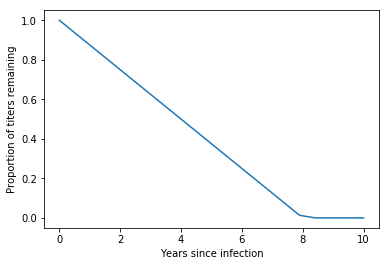

In [35]:
#### Model the waning of cross-protective immunity
def get_gamma(n):
    ''' 
    Per Leah's data, modeling post-primary titer decay as roughly linear with a 4-year half-life.
    '''
    return max(-0.125*n + 1.0, 0.0000000001)
plt.plot([x for x in linspace(0,10,num=20)], [get_gamma(x) for x in linspace(0,10,num=20)])
plt.xlabel('Years since infection')
plt.ylabel('Proportion of titers remaining')

## Estimate relative population exposure to genotype j from sequence frequencies  
x(j,y) = Number of j-genotype sequences in year y \ Total number of sequences in year y


In [36]:
#### Frequencies of genotype j
def get_x(j,y, frequencies):
    ''' return the frequency of j in a given season '''
    return frequencies[j][y]

## Estimate antigenic distance between past strains and currently circulating from dTiter values   
  
The tree model maps changes in antigenic phenotype to the tree, where the total antigenic distance between genotypes i and j is simply the sum of all titer drops that occur on branches along the tree path between i and j.
  
$$ D_{ij} = \sum_{b \in path_{ij}} d_b $$
  
As this model is additive, we can separate out the titer drops that occur on branches _between_ serotypes I and J:
$$D_{IJ} = \sum_{b \in path_{IJ}}d_b$$  
 
and the titer drops that occur on branches _within_ serotype I (i.e., from the MRCA of serotype I to genotype i):  
$$D_{Ii} = \sum_{b \in path_{Ii}} d_b$$  
$$D_{Jj} = \sum_{b \in path_{Jj}} d_b$$  

Such that $$ D_{ij} = D_{IJ} + D_{Ii} + D_{Jj}$$   

In [37]:
#### Titers for virus i, serum j
def get_D_ij(i,j, titers):
    ''' return dTiter between i and j'''
    pair = tuple(sorted([i,j])) # sort alphabetically to avoid key errors
    if i == j: # identical genotypes
        return {'D_inter': 0., 'D_intra': 0.}
    elif i[4] == j[4]: # same serotype, different genotypes
        return {'D_inter': 0., 'D_intra': titers['intra_dTiter'][pair]}
    else: # different serotypes and genotypes
        return {'D_inter': titers['inter_dTiter'][pair], 'D_intra': titers['intra_dTiter'][pair]}
  

## Estimate the probability of protection from drops in titer based on cohort data  

For now, use reasonable values to guesstimate the probability that an individual is protected from symptomatic infection with genotype j given recovery from genotype i, based on observed cohort study outcomes.

(0, 6)

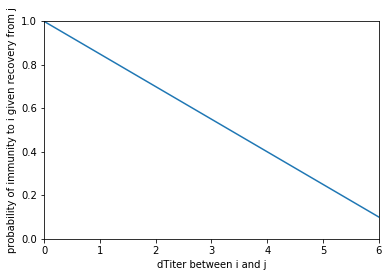

In [38]:
def calc_C_from_dTiter(dTiter):
    return 1. - 0.15*dTiter

def get_C_D_ij(D_ij):
        return {'C_inter':calc_C_from_dTiter(D_ij['D_inter']),
            'C_intra': calc_C_from_dTiter(D_ij['D_intra'])}

test_vals = linspace(0,6,num=20)
plt.plot(test_vals, [calc_C_from_dTiter(x) for x in test_vals])
plt.xlabel('dTiter between i and j')
plt.ylabel('probability of immunity to i given recovery from j')
plt.ylim(0,1)
plt.xlim(0,6)

## Calculate the population immunity against virus i of a random post-primary/pre-secondary individual drawn from the population at the start of a given season

### Variables
$$D(i,j)$$ antigenic distance, in log2 titer values, between viruses i and j.  
$$C(D(i,j))$$ probability of protection against virus j given previous recovery from virus i.  
$$n$$ how many years ago a previous exposure occurred.  
$$\gamma(n)$$ the proportion of neutralizing titers expected to remain n years after exposure  
$$Y$$ current season of interest  
$$y = Y-n$$ a previous season, where Y must be > n
$$x_y(i)$$ the relative frequency of genotype i in a specific previous year, y  
  
### Calculate frequency-weighted population immunity accrued in one season  
$$\hat{T_y}(i) = \sum_jx_y(j)*C(D(i,j))$$  
The expected population immunity to i, accrued in a given year, is the frequency-weighted immunity against i conferred by each circulating genotype, j.

### Calculate the population immunity accrued over the past 5 seasons  
$$\hat{T_Y}(i) = \sum_{n=1}^{5}(\gamma(n)*\sum_j (x_{Y-n}(j)*C(D(i,j))))$$

To isolate the effects of inter-serotype and intra-serotype antigenic distance, we can rewrite this as:  
$$\hat{T_Y}(i) = \sum_{n=1}^{5}(\gamma(n)*\sum_j (x_{Y-n}(j)*C(D(I,J)+D(I,i)+D(J,j))))$$  
Because C is a linear function of D(ij):
$$\hat{T_Y}(i) = \sum_{n=1}^{5}(\gamma(n)* \sum_j (x_{Y-n}(j) * C(D(I,J)) + x_{Y-n}(j) *C(D(I,i) + D(J,j)))) $$  



In [39]:
#### Calculate cumulative exposure to genotype i at the START of each season we have data for
def calc_population_exposure(i, all_Y, N, J, frequencies, titers):
    ''' Calculate population immunity to genotype i at the start of each season.
    i = genotype of interest
    all_Y = all years we have data for
    N = number of years in the past to sum over
    J = all genotypes
    '''

                        # starting seasons of interest
    valid_Y = all_Y[N:] # Only look at years where index(Y) > N, i.e. where we have data for at least N years before Y 

    population_exposure = {'total_exposure': [],
                            'serotype_exposure': [], 
                          'genotype_exposure': []}
        
    for Y in valid_Y: # each starting season of interest
        past_Y = [Y - n for n in range(1, N)] # past N seasons before Y
        cumulative_genotype_exposure = 0.
        cumulative_serotype_exposure = 0.
        
        for n, y in enumerate(past_Y, start=1): # for each of the past n seasons before Y
            gamma = get_gamma(n)

            for j in J: # for each genotype
                D_ij = get_D_ij(i,j,titers)
                C_D_ij = get_C_D_ij(D_ij)
                
                j_frequency = get_x(j, y, frequencies) # frequency of j in this previous season
                
                genotype_exposure = C_D_ij['C_intra']*j_frequency*gamma
                serotype_exposure = C_D_ij['C_inter']*j_frequency*gamma
              
                cumulative_genotype_exposure += genotype_exposure
                cumulative_serotype_exposure += serotype_exposure
                
        population_exposure['genotype_exposure'].append(cumulative_genotype_exposure)
        population_exposure['serotype_exposure'].append(cumulative_serotype_exposure)
        population_exposure['total_exposure'].append(cumulative_genotype_exposure+cumulative_serotype_exposure)
    
    return pd.DataFrame(population_exposure, index=valid_Y)

In [55]:
population_exposure = { i: calc_population_exposure(i, seasons, 5, genotypes, genotype_frequencies, titers)
                      for i in genotypes}
for i, exposure in population_exposure.items():
    valid_seasons = delta_genotype_frequencies.index
    exposure = exposure.loc[exposure.index.isin(valid_seasons)]
    exposure['delta_frequency'] = delta_genotype_frequencies[i]
    population_exposure[i] = exposure

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
print population_exposure.values()[0].head()

      genotype_exposure  serotype_exposure  total_exposure  delta_frequency
1985           2.520361           2.384384        4.904744        -0.004250
1986           2.481396           2.329684        4.811081        -0.026800
1987           2.472419           2.328622        4.801042        -0.127375
1988           2.517459           2.406345        4.923804        -0.060350
1989           2.571498           2.489724        5.061222         0.161650


In [57]:
valid_genotypes = [i for i in genotypes if max(genotype_frequencies[i]) >= 0.1]

all_r2 = []
for i in valid_genotypes:
    df = population_exposure[i]
#     x = df.as_matrix(columns=['genotype_exposure', 'serotype_exposure'])
    x = df['total_exposure'].values
    x = sm.add_constant(x, prepend=True)
    y = df['delta_frequency'].values

    results = smf.OLS(y,x).fit()
    all_r2.append(round(results.rsquared, 2))
    if results.rsquared >= 0.3:
        print 'GENOTYPE %s'%i
        print results.summary()
        
print 'ALL R^2 VALUES', all_r2

GENOTYPE DENV2_ASIANAMERICAN
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     14.43
Date:                Thu, 02 Nov 2017   Prob (F-statistic):           0.000829
Time:                        14:12:17   Log-Likelihood:                 17.633
No. Observations:                  27   AIC:                            -31.27
Df Residuals:                      25   BIC:                            -28.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3707  

In [58]:
#### Plot
    
def plot_exposure_delta_frequencies(i, ax, population_exposure, **kwargs):
    
    gt_x = population_exposure[i]['genotype_exposure']
    st_x = population_exposure[i]['serotype_exposure']
    total_x = population_exposure[i]['total_exposure']
    y = population_exposure[i]['delta_frequency']

    sns.regplot(gt_x, y, label='D(Ii)+D(Jj)', ax=ax)
#     sns.regplot(st_x, y, label='D(IJ)', ax=ax)
#     sns.regplot(total_x, y, label='Total D(ij)', ax=ax)
    
    ax.set_title(i)
    ax.set_xlabel('Population immunity')
    ax.set_ylabel('5-yr change in frequency')

    
def plot_time_frequencies_exposure(i, ax, population_exposure, frequencies, 
                                   min_val, max_val, **kwargs):
    
    time = genotype_frequencies[i].index.tolist()
    frequencies = genotype_frequencies[i].tolist()
    
    exposure = population_exposure[i].tolist()
    exposure = [x / max_val for x in exposure] # Norm so everything is between 0 and 1 for the cmap
    
    
    c = [cm.autumn_r(e) for e in exposure]
    ax.plot(time, frequencies, '-', c='gray')
    ax.scatter(time,frequencies,c=c, zorder=5, s=20)
    
    ax.set_title(i)
    ax.set_xlabel('Season')
    ax.set_ylabel('Genotype Frequency')
#     ax.set_ylim(0, 0.5)
    
#     if 'colorbar' in kwargs and kwargs['colorbar'] == True:
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('right', size='5%', pad=0.05)

#         im = ax.imshow(c)#, cmap='autumn_r')

#         plt.colorbar(im, cax=cax, orientation='vertical')

In [59]:
def plot_all_j_vals(plot_fn, population_exposure, frequencies, 
                       save=False, plot_name=None, **kwargs):
    sns.set(style='whitegrid', font_scale=1.1, palette='pastel')
    n_j_vals = len(population_exposure.keys())
    ncols = 4
    nrows = int(ceil(n_j_vals/ncols))
    
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True, figsize=(12,8), sharey=True, sharex=True)
    
    for j, ax in zip(sorted(population_exposure.keys()), axes.flatten()):
        plot_fn(j, ax, population_exposure, **kwargs)
        
    if 'title' in kwargs:
        plt.suptitle(kwargs['title'], va='bottom', size=24)

    plt.tight_layout()
    
    if save:
        plt.savefig(out_path+'/'+dataset_name+plot_name+'.png')
        
    if 'cbar' in kwargs:
        cax = fig.add_axes([1.0, 0.1, 0.02, 0.9], frame_on=False)
        cb = mpl.colorbar.ColorbarBase(cax,cmap='autumn_r',
                                       norm=mpl.colors.Normalize(vmin=min_val,vmax=max_val),orientation='vertical',alpha=1.0,drawedges=False)
        

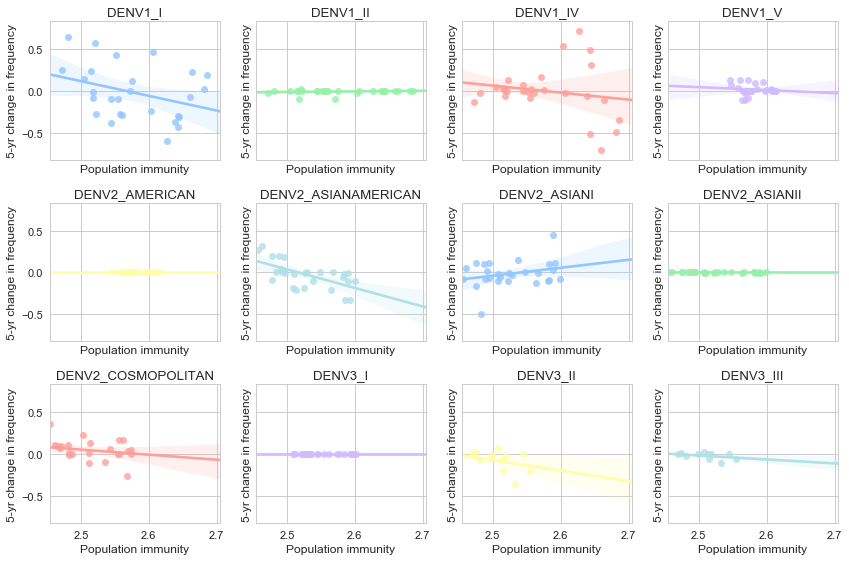

In [60]:
plot_all_j_vals(plot_exposure_delta_frequencies, population_exposure, genotype_frequencies)

In [83]:
# plot_all_j_vals(plot_time_frequencies_exposure, genotype_exposure_antigenic, genotype_frequencies, 
#                 min_val = min_gt_ant_val, max_val = max_gt_ant_val,
#                    title='Genotype frequencies over time in %s,\ncolored by expected titer'%dataset_name, 
#                    cbar=True)

In [84]:
# def plot_pooled_exposure_frequencies(population_exposure, frequencies = genotype_frequencies, 
#                        save=False, plot_name=None, title=None):
#     sns.set(style='whitegrid', font_scale=1.2, palette='pastel')
#     fig, ax = plt.subplots()
    
#     seasons_of_interest = population_exposure.values()[0].index.values
#     genotypes = population_exposure.keys()
    
#     pooled_frequencies = []
#     pooled_exposure = []
    
#     for genotype in genotypes:
#         pooled_exposure += population_exposure[genotype][seasons_of_interest].tolist()
#         pooled_frequencies += frequencies[genotype][seasons_of_interest].tolist()
    
#     ax = sns.regplot(pd.Series(pooled_exposure), pd.Series(pooled_frequencies), scatter_kws={'alpha': 0.6})
#     ax.set_xlabel('dTiter between population sera and virus i')
#     ax.set_ylabel('Frequency of virus i')
#     ax.set_ylim(bottom=0)
        
#     if title:
#         ax.set_title(title, size=24)
#     plt.tight_layout()
#     plt.show()
    
#     if save:
#         plt.savefig(out_path+'/'+dataset_name+plot_name+'.png')

#     fit = linregress(pooled_exposure, pooled_frequencies)
#     return fit
        

In [85]:
# def plot_pooled_exposure_delta_frequencies(population_exposure, frequencies, years_forward=3, 
#                                        save=False, plot_name=None, title=None):
    
#     sns.set(style='whitegrid', font_scale=1.2, palette='pastel')
#     fig, ax = plt.subplots()
    
#     valid_seasons = population_exposure.values()[0].index.tolist() # all available seasons
#     delta_seasons = zip(valid_seasons[years_forward:], valid_seasons) # [(S + N season, S season)]
    
#     def delta_f(i):
#         return [frequencies[i][s2] - genotype_frequencies[i][s1] for (s2, s1) in delta_seasons]
    
#     def pop_exp(i):
#         return population_exposure[i][valid_seasons[:-1*years_forward]].tolist()
    
#     pooled_exposure = []
#     pooled_delta_f = []
    
#     for i in population_exposure.keys():
#         pooled_exposure += pop_exp(i)
#         pooled_delta_f += delta_f(i)
        
    
#     sns.regplot(pd.Series(pooled_exposure),pd.Series(pooled_delta_f), ax=ax, scatter_kws={'alpha': 0.6})
    
#     ax.set_xlabel('dTiter(population sera, virus i)')
#     ax.set_ylabel('%d-yr change in frequency'%years_forward)
    
#     if title:
#         ax.set_title(title, size=24)
        
#     plt.tight_layout()
    
#     if save:
#         plt.savefig(out_path+'/'+dataset_name+plot_name+'.png')
        
#     fit = linregress(pooled_exposure, pooled_delta_f)
#     return fit

